In [1]:
from crpropa import *
import pylab as pl
import numpy as np 
from aab_subroutines import * 
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.coordinates import SkyCoord
from astropy import units as u
%matplotlib inline

print (mpl.__version__)

def CoLat2Lat(latitude):
    return (np.pi/2 - latitude)

def Lat2CoLat(latitude):
    return (np.pi/2 - latitude)

def Convert2Plot(lon):
    lon[(lon > np.pi)] = lon[(lon > np.pi)] - (2.0*np.pi)
    lon[(lon <= np.pi)] = -lon[(lon <= np.pi)]
    return lon

def add_composition_run(sim, source, Zs, mass, names, fracs, gamma, rcut, weights):
    composition = SourceComposition(60.0 * EeV, rcut/1e18 * EeV, -gamma)
    
    for i in range(len(Zs)):
        composition.add(mass[i], Zs[i],  fracs[i])  # H
    source.add( composition )
    
    # run simulation
    sim.setShowProgress(True)
    sim.run(source, 10000, True)
    


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/csgraph/__init__.py:148: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/csgraph/__init__.py:150: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._traversal import breadth_first_order, depth_first_order, \
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/csgraph/__init__.py:152: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._min_spanning_tree import 

2.2.3


0
6.533412283513656e+22
1.2379585024020948e+25
CenAcor 0.004222055760891134 0.8
1
1.1021091088077249e+22
1.4100046269693433e+25
M87 0.0007816351008553727 1.0
2
9.739634916559442e+21
1.417964915731564e+25
FornaxA 0.0 0.0
3
6.729093440103572e+20
1.5059438511537238e+25
NGC-1275 9.830383487994131e-05 2.2
4
6.937471162050329e+20
1.47795549408066e+25
IC-310 4.693964865542639e-05 1.0
5
2.6928442903248994e+20
1.54164369363658e+25
3C-264 8.73367919396717e-06 0.5
6
5.5089048423926465e+20
1.5152026174710166e+25
TXS-0149+710 1.8178772854773076e-05 0.5
7
0.0
1.5107729178476077e+25
Mkn-421 0.0 54.0
8
0.0
1.5011912275307935e+25
PKS-0229-581 0.0 0.5
9
6.7321107258122486e+19
1.4539117034803103e+25
Mkn-501 9.631114651715237e-05 20.8
10
0.0
1.4999095653290063e+25
1ES-2344+514 0.0 3.3
11
0.0
1.5346410279419618e+25
Mkn-180 0.0 1.9
12
0.0
1.4587761599518517e+25
1ES-1959+650 0.0 6.8
13
0.0
1.4608239054022024e+25
AP-Librae 0.0 1.7
14
0.0
1.5016506381934948e+25
TXS-0210+515 0.0 0.9
15
0.0
1.455521143989754e+25

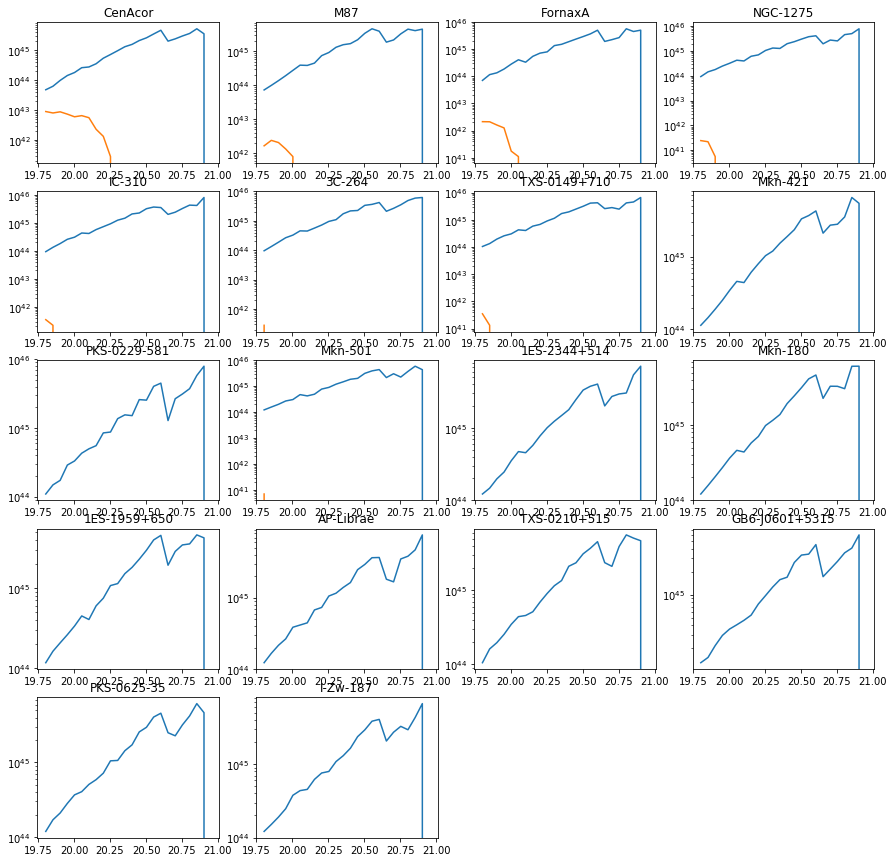

In [6]:
def flux_to_weight(distance):
    Zs = [1,2,7,14,26]
    mass = [1,4,14,28,56]
    names = ["H", "He", "N", "Si", "Fe"]
    #fracs = [0.125,0.586,0.246,0.042,0.0]
    fracs = [0.064, 0.467, 0.375, 0.094, 0.0]
    #fracs = [1.0,0.0,0.0,0.0,0.0]
    rcut = 10.0**18.66
    rcut = 6e19
    gamma = 1
    fname = "temp.txt"

    # calculate the spectrum from the source
    sim, source, output = setup_sim(fname, maxdistance=0)
    source = Source()  
    source.add(SourcePosition(Vector3d(distances[i], 0, 0) * Mpc))
    source.add(SourceIsotropicEmission())
    add_composition_run(sim, source, Zs, mass, names, fracs, gamma, rcut, None)
    output.close()
    
    d = np.genfromtxt(fname, names=True, invalid_raise=False)
    
    # observed quantities   
    Einit = d['E0'] * 1e18
    Efinal = d['E'] * 1e18
    lEinit = np.log10(d['E0']) + 18  # energy in log10(E/eV))
    lEfinal = np.log10(d['E']) + 18  # energy in log10(E/eV))
    
    Emin = np.log10(60.0 * 1e18)
    lEbins = np.arange(Emin, 21, 0.05)  # logarithmic bins
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2  # logarithmic bin centers
    dE = 10**lEbins[1:] - 10**lEbins[:-1]  # bin widths
    Ebins = 10.0 ** lEcens
    

    J_init = np.histogram(lEinit, bins=lEbins)[0] / dE
    J_final = np.histogram(lEfinal, bins=lEbins)[0] / dE
    
    plt.plot(lEcens, Ebins**3 * J_init, label="init")
    plt.plot(lEcens, Ebins**3 * J_final, label="final")
    plt.semilogy()
    
    select = (Ebins > Emin)
    
    weight = np.trapz(Ebins[select]*J_final[select], x=Ebins[select])
    print weight
    weight_denom = np.trapz(Ebins[select]*J_init[select], x=Ebins[select])
    print weight_denom
    weight /= weight_denom
                     
    return weight


source_cat = "radio-gals.dat"
l, b, distances, fluxes, atw_a, atw_b, atw_c, cont_a, cont_b, cont_c  = np.genfromtxt(source_cat, 
                                                                                       unpack=True, 
                                                                                       usecols = np.arange(1,11))
names = np.genfromtxt(source_cat, unpack=True, usecols = (0), dtype=str)

weight = np.zeros_like(fluxes)

plt.figure(figsize=(15,15))
                     
for i in range(len(l)):
    print i
    # set up the direction object
    plt.subplot(5,4,i+1)
    plt.title(names[i])
    weight[i] = flux_to_weight(distances[i]) * fluxes[i]
    

    
    print names[i], weight[i], fluxes[i]

weight = weight / np.sum(weight) * 100

for i in range(len(l)):
    print names[i], distances[i], fluxes[i], weight[i]
    
print (weight)